<img src="glm-plot.png" width="400" height="400">

# GLM Deep Dive
## Frequency Severity modelling

This notebook is a deep dive into [General Linear Models (GLM's)](https://online.stat.psu.edu/stat504/node/216/) with a focus on the GLM's used in insurance risk modeling and pricing ([Yan, J. 2010)](https://www.casact.org/education/rpm/2012/handouts/Session_4738_presentation_1068_0.pdf).I have used GLM's before including: a Logistic Regression for landslide geo-hazards (([Postance, 2017](https://onlinelibrary.wiley.com/doi/full/10.1002/esp.4202))), for modeling extreme rainfall and developing catastrophe models ([Postance, 2017](https://scholar.google.co.uk/scholar?oi=bibs&cluster=13784644545966658880&btnI=1&hl=en)). The motivation for this post is to develop a deeper knowledge of the assumptions and application of the models and methods used by Insurance Actuaries, and to better understand how these compare to machine learning methods.

In [1]:
import urllib.request
import shutil
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import Image
from IPython.core.display import HTML 

from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy import stats
from patsy import dmatrices,dmatrix
import statsmodels.api as sm
import statsmodels.formula.api as smf

### Case study dataset: motorcylce insurance
The [Ohlsson dataset](https://cran.r-project.org/web/packages/insuranceData/insuranceData.pdf#Rfn.dataOhlsson.1) is from a former Swedish insurance company Wasa. The data includes aggregated  customer, policy and claims data for 64,548 motocycle coverages for the period 1994-1998. The data is used extensively in actuarial training and sylabus worldwide [Ohlsson, (2010)](https://www.springer.com/gp/book/9783642107900#aboutBook).


Variables inclde:
 1. (0:2) agarald - The owners age, between 0 and 99, a numeric vector.
 1. (2:3) kon - The owners sex,factor with levels K (female) M (male).
 1. (3:4) zon - Geographic zone numbered from 1 to 7, in a standard classification of all Swedish parishes, anumeric vector
 1. (4:5) mcklass - MC class, a classification by the so called EV ratio, defined as (Engine power in kW x100) / (Vehicle weight in kg + 75), rounded to the nearest lower integer. The 75 kg represents the average driver weight. The EV ratios are divided into seven classes, a numeric vector
 1. (5:7) fordald - Vehicle age, between 0 and 99, a numeric vector
 1. (7:8) bonuskl - Bonus class, taking values from 1 to 7. 
  - A new driver starts with bonus class 1. For each claim free year the bonus class is increased by 1. 
  - After the first claim the bonus is decreased by  2. The  driver  can  not  return  to  class  7  with  less  than  6  consecutive  claim  free  years,  a numeric vector
 1. (8:16) duration - the number of policy years, a numeric vector
 1. (16:20) antskad - the number of claims, a numeric vector
 1. (20:) skadkost - the claim cost, a numeric vector

- *(n:n) are the columnar positions of the data*
- *data avaliable [here](https://staff.math.su.se/esbj/GLMbook/case.html)*

In [2]:
# read or get file
file_name='mccase.txt'

try: 
    file = open(file_name,'r')
except:
    url = 'https://staff.math.su.se/esbj/GLMbook/mccase.txt'
    # Download the file from `url` and save it locally under `file_name`:
    with urllib.request.urlopen(url) as response, open(file_name, 'wb') as out_file:
        shutil.copyfileobj(response, out_file)
    file = open(file_name,'r')

# load file
dat = list()
for line in file.readlines():
    dat.append([line[:2],line[2:3],line[3:4],line[4:5],line[5:7],line[7:8],line[8:16],line[16:20],str(line[20:]).replace('\n','')])
file.close()
df = pd.DataFrame(dat,columns=['Age','Sex','Geog','EV','VehAge','NCD','PYrs','Claims','Severity'])
df = df.astype({'Age':float,'Sex':'category','Geog':'category','EV':'category',
                'VehAge':int,'NCD':'category','PYrs':float,'Claims':int,'Severity':float}).copy()

# PYrs is the fraction of compelete policy years 
# there are some policies with 0.0 duration (1/365 = 0.00274 = 1 day)
# set these to 1 day
df.loc[df['PYrs']==0.0,'PYrs'] = 1.0/365.0

# single claim frequency indicator
df['Claim'] = (df['Claims']>=1).astype(int)

print(df.dtypes)

Age          float64
Sex         category
Geog        category
EV          category
VehAge         int32
NCD         category
PYrs         float64
Claims         int32
Severity     float64
Claim          int32
dtype: object


### EDA

- low number of claims and frequency (1% freq)

In [3]:
df.describe()

,Age,VehAge,PYrs,Claims,Severity,Claim
count,64548.000000,64548.000000,64548.000000,64548.000000,64548.000000,64548.000000
mean,42.416062,12.540063,1.010759,0.010798,264.017785,0.010380
std,12.980960,9.727445,1.307356,0.107323,4694.693604,0.101352
min,0.000000,0.000000,0.002740,0.000000,0.000000,0.000000
25%,31.000000,5.000000,0.463014,0.000000,0.000000,0.000000
50%,44.000000,12.000000,0.827397,0.000000,0.000000,0.000000
75%,52.000000,16.000000,1.000000,0.000000,0.000000,0.000000
max,92.000000,99.000000,31.339730,2.000000,365347.000000,1.000000


In [4]:
claims = df.loc[df['Claims']!=0]
claims.describe()

,Age,VehAge,PYrs,Claims,Severity,Claim
count,670.000000,670.000000,670.000000,670.000000,670.000000,670.0
mean,35.476119,7.965672,1.579415,1.040299,25435.552239,1.0
std,12.851056,6.768896,2.983317,0.196805,38539.415033,0.0
min,16.000000,0.000000,0.002740,1.000000,16.000000,1.0
25%,25.000000,2.000000,0.430137,1.000000,3031.500000,1.0
50%,30.000000,7.000000,0.790411,1.000000,9015.000000,1.0
75%,47.000000,12.000000,1.497945,1.000000,29304.500000,1.0
max,68.000000,55.000000,31.167120,2.000000,365347.000000,1.0


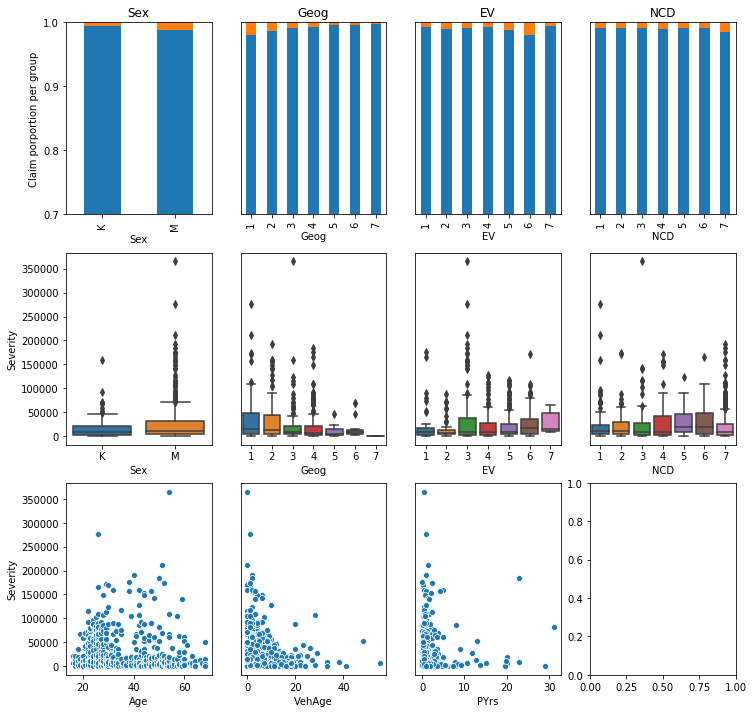

In [5]:
fig,axs=plt.subplots(3,4,figsize=(12,12),sharey=False)

# claim proportions by category
for ax,feat in zip(axs.flatten()[:4],df.select_dtypes(include='category').columns):
    ((pd.crosstab(df['Claim'],df[feat])) /
                    (pd.crosstab(df['Claim'],df[feat]).sum())).T.plot.bar(stacked=True,ax=ax,legend=False,title=None)
    ax.set_title(feat)
    ax.set_ylim(0.7,1)
    ax.set_yticks([])
axs[0,0].set_yticks(np.arange(0.7,1.0,0.1))
axs[0,0].set_ylabel('Claim porportion per group')

# severity by category
for col,ax in zip(df.select_dtypes(include='category').columns,axs.flatten()[4:]):
    sns.boxplot(x=col,y='Severity',data=claims,ax=ax)
    ax.set_yticks([])
    ax.set_ylabel('')

# severity by continuous
for col,ax in zip(['Age','VehAge','PYrs'],axs.flatten()[8:]):
    sns.scatterplot(x=col,y='Severity',data=claims,ax=ax)
    ax.set_yticks([])
    ax.set_ylabel('')

for ax in axs[1:3,0]:
    ax.set_ylabel('Severity')
    ax.set_yticks(np.arange(0,4e5,5e4))

### Modelling
- StatsModels (SM) uses patsy [formula notation](https://www.statsmodels.org/devel/example_formulas.html).
- This includes: [notation for categorical variables ](https://www.statsmodels.org/devel/contrasts.html), setting [reference/base levels](https://stackoverflow.com/a/22439820/4538066), [encoding options](https://www.statsmodels.org/devel/contrasts.html), and [operators](https://www.statsmodels.org/devel/example_formulas.html#categorical-variables).

In [6]:
# train-test splits stratifies on claims
# take copies to overcome chained assignment
train,test = train_test_split(df,test_size=0.3,random_state=1990,stratify=df['Claim'])
train = df.loc[train.index].copy()
test = df.loc[test.index].copy()

### $Claim Frequency$

For predicting the occurence of a single claim (i.e. binary classification) one can use the Binomial distribution (a.k.a Bernoulli trial or coin-toss experiment).

When predicting claim counts or frequency, $Y$, a model that prodices Poisson distributed outputs is required. For instance, a Poisson model is suitable for estimating the number of insurance claims per policy per year, or to estimate the number of car crashes per month. 

The key components and assumptions of a Poisson distributed process are: 
 1. event occurence is independant of other events. 
 1. events occur within a fixed period of time.
 1. the mean a variance of the distribution are equal e.g. $mu(X) = Var(X) = λ$
 
[*STAT 504: Poisson Distribution*](https://online.stat.psu.edu/stat504/node/57/)


If the mean and variance are unequal the distribution is said to be over-disperesed (var > mean) or under-dispersed (var < mean). Over-dispersion commonly arises in data where there are large number of zero's (a.k.a [zero-inflated](https://en.wikipedia.org/wiki/Zero-inflated_model)).

In the case of zero-inflated data, it is "*A sound practice is to estimate both Poisson and negative binomial models.*" [*Cameron, 2013*](http://faculty.econ.ucdavis.edu/faculty/cameron/racd2/). Also see this practical example for [beverage consumption in pdummy_xyhon](https://dius.com.au/2017/08/03/using-statsmodels-glms-to-model-beverage-consumption/)

In GLM's, link-functions are applied in order to make the mean outcome (prediction) fit to some linear model of input variables from other distributions. "*A natural fit for count variables that follow the Poisson or negative binomial distribution is the log link. The log link exponentiates the linear predictors. It does not log transform the outcome variable.*" - [*Count Models: Understanding the Log Link Function,TAF*](https://www.theanalysisfactor.com/count-models-understanding-the-log-link-function/)

For more information on link-functions see also [here](https://bookdown.org/castillo_sam_d/Exam-PA-Study-Manual/glms-for-classification.html#link-functions).

![link functions](https://i0.wp.com/www.theanalysisfactor.com/wp-content/uploads/2016/12/StataCombos-CM2-Blog-JM.png?w=535&ssl=1)

Lastly, for any form of count prediction model one can also set an offset or exposure. 

An offset, if it is known, is applied in order to account for the relative differences in exposure time for of a set of inputs. For example, in insurance claims we might expect to see more claims on an account with 20 years worth of annual policies compared to an account with a single policy year. Offsets account for the relative exposure|surface area|population size|etc and is akin to the relative frequency of occurence ($Claims/years$). See these intuititve SO answers [here](https://stats.stackexchange.com/questions/232666/should-i-use-an-offset-for-my-poisson-glm), [here](https://github.com/statsmodels/statsmodels/issues/1486#issuecomment-40945831), and [here](https://stats.stackexchange.com/questions/25415/using-offset-in-binomial-model-to-account-for-increased-numbers-of-patients).

In [7]:
# Mean & Variance
mu = df.Claims.mean()
var = np.mean([abs(x - mu)**2 for x in df.Claims])
print(f'mu =  {mu:.4f}\nvar = {var:.4f}')

mu =  0.0108
var = 0.0115


Here we observe an over-dispersed zero-inflated case as the variance of claim occurence ($v=0.0115$) exceeds its mean ($mu=0.0108$).

As suggested in Cameron (2013) we should therefore try both $Poisson$ and $Negative Binomial$ distributions.

For good measure, and to illustrate its relationship, lets also include a $Binomial$ distribution model. The Binomial model with a logit link is equivalent to a binary Logistic Regression model [[a](https://www.researchgate.net/post/what_is_the_difference_between_running_a_binary_logistic_regression_and_generalised_linear_model),[b](https://towardsdatascience.com/the-binomial-regression-model-everything-you-need-to-know-5216f1a483d3)]. Modelling A binary outcome is not a totally unreasonable approach in this case given that the number of accounts with claims $n>1$ is low (22) and as the $Binomial$ distribution extends to a $Poisson$ when trials $N>20$ is high and $p<0.05$ is low (see [wiki](https://en.wikipedia.org/wiki/Poisson_distribution#Related_distributions), [here](https://math.stackexchange.com/questions/1050184/difference-between-poisson-and-binomial-distributions) and [here](https://www.itl.nist.gov/div898/handbook/pmc/section3/pmc331.htm)).

However, there is one change we need to make with the Binomial model. That is to alter the way we handle exposure. A few hours of research on the matter led me down the rabbit hole of conflicting ideas in textbooks, papers [[i](https://doi.org/10.1093/ije/dyu029)] and debates on CrossValidated [[a](https://stats.stackexchange.com/questions/246318/difference-between-offset-and-weights),[b](https://stats.stackexchange.com/questions/25415/using-offset-in-binomial-model-to-account-for-increased-numbers-of-patients/35478)]. In contrast to poisson and neg binomial there is no way to add a constant term or offset in the binomial formulation [(see here)](https://stats.stackexchange.com/a/35478/100439). Rather it is appropriate to either: [include the exposure as a predictor variable](https://stats.stackexchange.com/a/35436/100439), or to use weights for each observation (see [here](https://stackoverflow.com/a/62798889/4538066) and the [statsmodels guidance on methods for GLM with weights and observed freqeuncies](https://www.statsmodels.org/stable/generated/statsmodels.genmod.generalized_linear_model.GLM.html#statsmodels.genmod.generalized_linear_model.GLM). I opted for the weighted GLM. The model output of the binomial GLM is the probability of at least 1 claim occuring weighted by the observation time $t=Pyrs$. Note there is no equivalent setting on the predict side, the predictions assume a discrete equivalent time exposure t=1.

In addition it is common in insurance risk models to use a [quasi-poisson or zero inflated poisson (ZIP)](https://towardsdatascience.com/an-illustrated-guide-to-the-zero-inflated-poisson-model-b22833343057) model in scenarios with high instances of zero claims. In data science and machine learning we would refer to this as an unbalanced learning problem (see bootstrap, cross validation, SMOTE). The ZIP model combines:
 - a binomial model to determine the likelihood of one or more claims occuring (0/1)
 - a negative binomial or poisson to estimate the number of claims (0...n)
 - a severity model to estimate the avg size of each claim (1...n)

In [8]:
# # examples of formula notation in smf
# print(' + '.join(train.columns))
# expr = "Claims ~ Age+C(Sex)+C(Geog, Treatment(reference=3))+EV+VehAge+NCD"

# including PYrs as parameter commented out in glm()
expr = "Claims ~ Age + Sex + Geog + EV + VehAge + NCD " # + np.log(PYrs)

FreqPoisson = smf.glm(formula=expr,
                      data=train,
                      offset=np.log(train['PYrs']),
                      family=sm.families.Poisson(link=sm.families.links.log())).fit()

FreqNegBin = smf.glm(formula=expr,
                      data=train,
                      offset=np.log(train['PYrs']),
                      family=sm.families.NegativeBinomial(link=sm.families.links.log())).fit()

# uses the binary "Claim" field as target
# offset is Pyrs (Years complete 0.0...n)
# aka a binary logistic regression
FreqBinom = smf.glm(formula="Claim ~ Age + Sex + Geog + EV + VehAge + NCD " ,
                    data=train,
                    freq_weights=train['PYrs'],
                    family=sm.families.Binomial(link=sm.families.links.logit())).fit()

### Model coefficients

***Poisson Parameters***
- [Poisson GLM params](https://stackoverflow.com/questions/14923684/interpreting-the-output-of-glm-for-poisson-regression)
- [Find lambda](https://stackoverflow.com/questions/25828184/fitting-to-poisson-histogram)

We can derive the model output using predict or the raw coefficients. Sampling the poisson rate ($lambda$) illustrates the difference in predicted rates for the intercept and for a when a driver is male. 

In [12]:
FreqPoisson.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 Claims   No. Observations:                45183
Model:                            GLM   Df Residuals:                    45161
Model Family:                 Poisson   Df Model:                           21
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2541.7
Date:                Sun, 11 Oct 2020   Deviance:                       4135.6
Time:                        19:29:48   Pearson chi2:                 1.83e+05
No. Iterations:                    22                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9052      0.284     -3.184      0.001      -1.462      -0.348
Sex[T.M]       0.3881      0.162      2.392      0.017       0.070       0.706
Geog[T.2]     -0.6478      0.135     -4.811      0.000      -0.912      -0.384
Geog[T.3]     -0.9043      0.137     -6.606      0.000      -1.173      -0.636
Geog[T.4]     -1.3826      0.123    -11.254      0.000      -1.623      -1.142
Geog[T.5]     -1.5218      0.389     -3.912      0.000      -2.284      -0.759
Geog[T.6]     -1.4581      0.315     -4.623      0.000      -2.076      -0.840
Geog[T.7]    -22.0308   1.77e+04     -0.001      0.999   -3.47e+04    3.46e+04
EV[T.2]        0.0923      0.237      0.389      0.697      -0.372       0.557
EV[T.3]       -0.4219      0.199     -2.115      0.034      -0.813      -0.031
EV[T.4]       -0.3602      0.215     -1.678      0.093      -0.781       0.061
EV[T.5]       -0.0334      0.204     -0.164      0.870      -0.433       0.367
EV[T.6]        0.4132      0.202      2.042      0.041       0.017       0.810
EV[T.7]        0.3316      0.483      0.687      0.492      -0.614       1.278
NCD[T.2]      -0.1441      0.181     -0.795      0.426      -0.499       0.211
NCD[T.3]       0.0184      0.192      0.096      0.923      -0.357       0.394
NCD[T.4]       0.3047      0.184      1.660      0.097      -0.055       0.664
NCD[T.5]      -0.0535      0.215     -0.249      0.804      -0.475       0.368
NCD[T.6]       0.0967      0.206      0.470      0.639      -0.307       0.501
NCD[T.7]       0.1835      0.137      1.334      0.182      -0.086       0.453
Age           -0.0580      0.004    -13.633      0.000      -0.066      -0.050
VehAge        -0.0762      0.008     -9.781      0.000      -0.091      -0.061
==============================================================================
"""

Lambda intercept: 0.40
Lambda intercept + male: 0.60


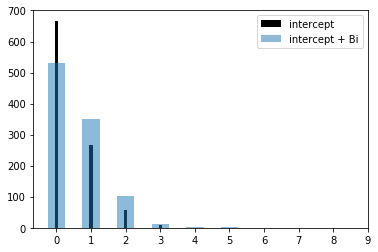

In [11]:
fig,axs = plt.subplots(1,1)

bins = np.arange(0,10,1)
n = 1000
print(f'Lambda intercept: {np.exp(FreqPoisson.params[0]):.2f}\nLambda intercept + male: {np.exp(FreqPoisson.params[0]+FreqPoisson.params[1]):.2f}')

axs.hist(np.random.poisson(lam=np.exp(FreqPoisson.params[0]),size=n),
         bins=bins,rwidth=0.1,
         alpha=1,label='intercept', align='left',color='k')

axs.hist(np.random.poisson(lam=np.exp(FreqPoisson.params[0]+FreqPoisson.params[1]),size=n),
         bins=bins,rwidth=0.5,
         alpha=0.5,label='intercept + Bi',align='left')
axs.set_xticks(bins)
axs.legend();

In [13]:
# get prediction to access easy confidence intervals
gp = FreqPoisson.get_prediction(test)
gp.summary_frame(alpha=0.05)[:2]

C:\ProgramData\Anaconda3\envs\machine-learning\lib\site-packages\statsmodels\genmod\families\links.py:521: RuntimeWarning: overflow encountered in exp
  return np.exp(z)


,mean,mean_se,mean_ci_lower,mean_ci_upper
0,0.036901,0.007723,0.024485,0.055614
1,0.030348,0.006528,0.019908,0.046263


***Negative binomial coefficients and incidence rate ratio***

 - https://stats.idre.ucla.edu/stata/dae/negative-binomial-regression/
 - https://stats.stackexchange.com/questions/17006/interpretation-of-incidence-rate-ratios
 - https://stats.stackexchange.com/questions/414752/how-to-interpret-incidence-rate-ratio
 - https://www.cdc.gov/csels/dsepd/ss1978/lesson3/section5.html

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Claims   No. Observations:                45183
Model:                            GLM   Df Residuals:                    45161
Model Family:        NegativeBinomial   Df Model:                           21
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2535.9
Date:                Sun, 11 Oct 2020   Deviance:                       3754.7
Time:                        19:30:06   Pearson chi2:                 1.82e+05
No. Iterations:                    21                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.8851      0.288     -3.069      0.0

C:\ProgramData\Anaconda3\envs\machine-learning\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


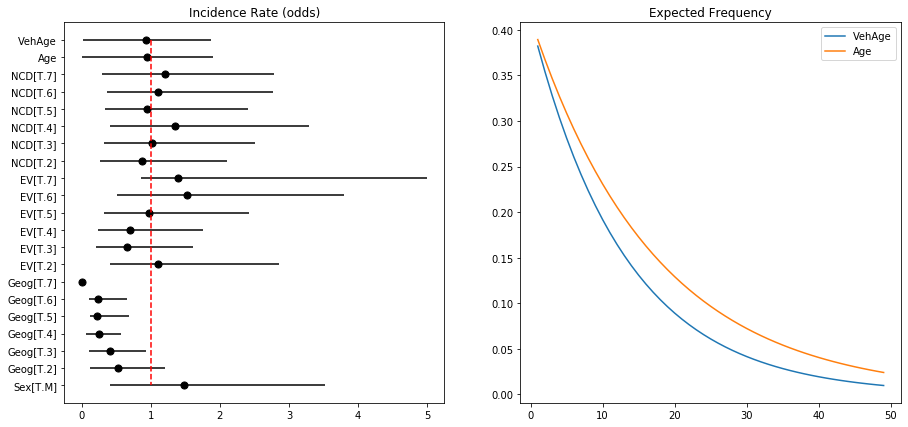

In [14]:
print(FreqNegBin.summary())
X_ = np.arange(0,len(FreqNegBin.params[1:]))
irr_ = np.exp(FreqNegBin.params[1:])
frq_ = [np.exp(FreqNegBin.params[0]+x) for x in FreqNegBin.params[1:]]
df_ = pd.DataFrame({'X':X_,'irr':irr_,'frq':frq_})
df_['lwr'] = np.exp(FreqNegBin.conf_int()[0])
df_['upr'] = np.exp(FreqNegBin.conf_int()[1])

fig,axs = plt.subplots(1,2,figsize=(15,7))
ages_ = np.arange(1,50,1)

axs[0].set_title('Incidence Rate (odds)')
axs[0].scatter(x=df_.irr,y=df_.X,s=50,c='k',linestyle='None')
axs[0].errorbar(x=df_.irr,y=df_.X,xerr=(df_.lwr,df_.upr),c='k',linestyle='None')
axs[0].plot([1,1],[20,0],'r--')
axs[0].set_yticks(df_.X)
axs[0].set_yticklabels(irr_.index)

axs[1].set_title('Expected Frequency')
axs[1].plot(ages_,[np.exp(FreqNegBin.params[0]+FreqNegBin.params['VehAge']*i) for i in ages_],label='VehAge')
axs[1].plot(ages_,[np.exp(FreqNegBin.params[0]+FreqNegBin.params['Age']*i) for i in ages_],label='Age')
axs[1].legend();

***Binomial Model Coefficients and Logits Log-Odds, Odds and Probabilties***
- https://sebastiansauer.github.io/convert_logit2prob/

In [15]:
print(FreqBinom.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Claim   No. Observations:                45183
Model:                            GLM   Df Residuals:                 45690.29
Model Family:                Binomial   Df Model:                           21
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3504.3
Date:                Sun, 11 Oct 2020   Deviance:                       7008.7
Time:                        19:30:06   Pearson chi2:                 4.72e+04
No. Iterations:                    24                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.7911      0.289     -9.672      0.0

In [16]:
# Example conversions from logits to probabilities
const = FreqBinom.params[0]
odds = np.exp(const)
probability = odds / (1+odds)
print(f'Intercept: p = {probability:.3f}')
_ = np.exp(const+FreqBinom.params[1])/(1+(np.exp(const+FreqBinom.params[1])))
print(f'Intercept + Male: p = {_:.3f} ({_-probability:.3f})')

Intercept: p = 0.058
Intercept + Male: p = 0.114 (0.056)


C:\ProgramData\Anaconda3\envs\machine-learning\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
C:\ProgramData\Anaconda3\envs\machine-learning\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


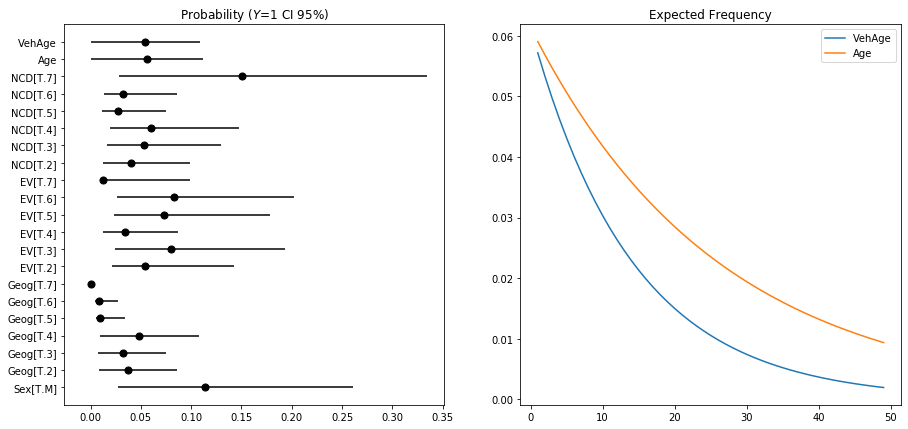

In [17]:
X_ = np.arange(0,len(FreqBinom.params[1:]))
odds = np.exp(FreqBinom.params[1:])
frq_ = [np.exp(FreqBinom.params[0]+x)/(1+np.exp(FreqBinom.params[0]+x)) for x in FreqBinom.params[1:]]
df_ = pd.DataFrame({'X':X_,'irr':irr_,'frq':frq_})
df_['lwr'] = [np.exp(FreqBinom.params[0]+x)/(1+np.exp(FreqBinom.params[0]+x)) for x in FreqBinom.conf_int()[0][1:]]
df_['upr'] = [np.exp(FreqBinom.params[0]+x)/(1+np.exp(FreqBinom.params[0]+x)) for x in FreqBinom.conf_int()[1][1:]]

fig,axs = plt.subplots(1,2,figsize=(15,7))
ages_ = np.arange(1,50,1)

axs[0].set_title('Probability ($Y$=1 CI 95%)')
axs[0].scatter(x=df_.frq,y=df_.X,s=50,c='k',linestyle='None')
axs[0].errorbar(x=df_.frq,y=df_.X,xerr=(df_.lwr,df_.upr),c='k',linestyle='None')
axs[0].set_yticks(df_.X)
axs[0].set_yticklabels(irr_.index)

axs[1].set_title('Expected Frequency')
axs[1].plot(ages_,[np.exp(FreqBinom.params[0]+FreqBinom.params['VehAge']*i) for i in ages_],label='VehAge')
axs[1].plot(ages_,[np.exp(FreqBinom.params[0]+FreqBinom.params['Age']*i) for i in ages_],label='Age')
axs[1].legend();

### Prediction

,Age,Sex,Geog,EV,VehAge,NCD,PYrs,Claims,Severity,Claim,Fnb,Fpo,Fbi
57075,58.0,M,2,3,16,3,0.504110,0,0.0,0,0.001063,0.001076,0.003627
55016,56.0,M,3,4,25,7,0.931507,0,0.0,0,0.001088,0.001092,0.002342
2706,22.0,K,4,5,5,2,1.000000,0,0.0,0,0.016363,0.016223,0.013482
45173,50.0,M,4,2,13,4,0.950685,0,0.0,0,0.004336,0.004332,0.006090
8146,26.0,K,2,5,12,3,0.498630,0,0.0,0,0.009274,0.009231,0.007141


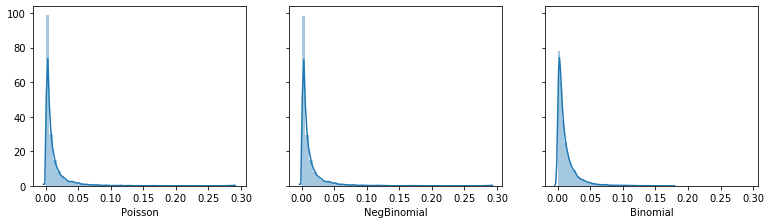

In [18]:
test['Fnb'] = FreqNegBin.predict(transform=True,exog=test,offset=np.log(test['PYrs']))
test['Fpo'] = FreqPoisson.predict(transform=True,exog=test,offset=np.log(test['PYrs']))
test['Fbi'] = FreqBinom.predict(transform=True,exog=test)

fig,axs = plt.subplots(1,3,figsize=(13,3.3),sharex=True,sharey=True)
sns.distplot(test['Fpo'],ax=axs[0],axlabel='Poisson')
sns.distplot(test['Fnb'],ax=axs[1],axlabel='NegBinomial')
sns.distplot(test['Fbi'],ax=axs[2],axlabel='Binomial')

test.sample(5)

Loooking at the model summaries, the histograms and results the of predicted values on the test, we see that each model weights covariates similarly and produces similar scores on the test data. ***Again note*** that the $Binomial$ model was only used to demonstrate its similarity in this case, but this may not hold for other data.

### $Claim Severity$


***After fitting a GLM-Gamma, how do we find the Gamma shape ($a$) and scale ($b$) params of predictions for $Xi$?***

"*Regression with the gamma model is going to use input variables Xi and coefficients to make a pre-diction about the mean of yi, but in actuality we are really focused on the scale parameter βi.  This is so because we assume that αi is the same for all observations, and so variation from case to case in μi=βiα is due simply to variation in βi.*" [technical overview of gamma glm](https://pj.freefaculty.org/guides/stat/Regression-GLM/Gamma/GammaGLM-01.pdf)

- [gamma handout](https://pj.freefaculty.org/guides/stat/Distributions/DistributionWriteups/Gamma/Gamma-02.pdf)
- [Gamma Choice of link function](http://people.stat.sfu.ca/~raltman/stat402/402L26.pdf)
- [exmaple finding scale in R](https://stat.ethz.ch/pipermail/r-help/2011-July/283736.html)
- [generalized linear model - Dispersion parameter for Gamma family - Cross Validated](https://stats.stackexchange.com/questions/247624/dispersion-parameter-for-gamma-family)
- [Pdummy_xyhon: Calculating scale/dispersion of Gamma GLM using statsmodels](https://stackoverflow.com/questions/60215085/calculating-scale-dispersion-of-gamma-glm-using-statsmodels)

[Alternatively Infer gamma params from CI](https://math.stackexchange.com/questions/2873763/is-it-possible-to-determine-shape-and-scale-for-a-gamma-distribution-from-a-mean?newreg=d61b4517cd304ecca335b8e69220bf0c)


- [gamma.shape.glm: Estimate the Shape Parameter of the Gamma Distribution R MASS](https://rdrr.io/cran/MASS/man/gamma.shape.glm.html)
- [The identity link function does not respect the domain of the Gamma family? - Cross Validated](https://stats.stackexchange.com/questions/356053/the-identity-link-function-does-not-respect-the-domain-of-the-gamma-family)

***Dummy data***

In [19]:
# sim data
#np.random.seed(1066)
y = np.random.gamma(shape=2, scale=3, size=10_000)
dummy_xy = pd.DataFrame({'Y':y,
                         'category':pd.cut(pd.Series(y),bins=[0,3,7,10,5000],right=True,labels=[1,2,3,4]),
                         'numerical':pd.Series(y * np.random.random(size=10000))
                  })

if dummy_xy.isnull().any().any():
    print('Nulls')

***MLE parameter estimations on raw data***

In [20]:
#### estimate params using MLE fit
print(stats.gamma.fit(dummy_xy['Y']))

(1.9744400923270682, -0.0036534137552974516, 3.07085008545754)


***GLM-Gamma Inverse-Power link***

C:\ProgramData\Anaconda3\envs\machine-learning\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:273: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)


Shape : 12.84855486898926
Scale X0:  0.1403777209417192
Scale Xi:  0.36677565068531026
Scale Xi:  0.6059174139537791


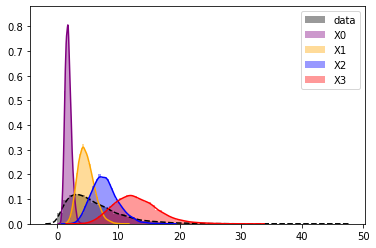

In [21]:
### Estimate scale (rate) using GLM-gamma with default inverse-power link
glm = smf.glm("Y ~ 1 + category + numerical", data=dummy_xy,family=sm.families.Gamma())
glm_fit = glm.fit()

# shape is
shape = 1/glm_fit.scale
print('Shape :',shape)

# Remeber we drop a reference category for modelling
# For each categorical level
# intercept scale is
X0 = glm_fit.scale/glm_fit.params[0]
print('Scale X0: ',X0)


# scale for each categorical value is
X1 = glm_fit.scale/(glm_fit.params[0]+glm_fit.params[1])
print('Scale Xi: ',X1)
X2 = glm_fit.scale/(glm_fit.params[0]+glm_fit.params[2])
print('Scale Xi: ',X2)

# and for the numerical when 
# category = 2
# numerical = max
X3 = glm_fit.scale/(glm_fit.params[0]+glm_fit.params[2]+glm_fit.params['numerical']*dummy_xy['numerical'].max())

# plot
sns.distplot(y,color='black',label='data',kde_kws={'linestyle':'--'})
sns.distplot(np.random.gamma(shape=shape,scale=X0,size=10000),color='purple',label='X0')
sns.distplot(np.random.gamma(shape=shape,scale=X1,size=10000),color='orange',label='X1')
sns.distplot(np.random.gamma(shape=shape,scale=X2,size=10000),color='blue',label='X2')
sns.distplot(np.random.gamma(shape=shape,scale=X3,size=10000),color='red',label='X3')
plt.legend();

In [22]:
glm_fit.params

Intercept        0.554431
category[T.2]   -0.342231
category[T.3]   -0.425982
category[T.4]   -0.467178
numerical       -0.001924
dtype: float64

In [23]:
# So remember the model gives us the predicted mean value 
dummy_xy['pred-inv'] = glm_fit.predict()
dummy_xy[:5]

,Y,category,numerical,pred-inv
0,5.216028,2,0.377220,4.728714
1,3.301647,2,2.995603,4.844136
2,6.626265,2,6.256119,4.995988
3,8.533480,3,1.796263,8.000466
4,5.356155,2,3.149176,4.851081


In [29]:
# manually sampling this distribution and finding the mean will give us the prediction
scale = glm_fit.scale/(glm_fit.params[0]+glm_fit.params['category[T.2]']+glm_fit.params['numerical']*dummy_xy['numerical'][0])
sample = np.random.gamma(shape=shape,scale=scale,size=1000)
np.mean(sample)

4.732454270663176

In [30]:
print('Bingo!')

Bingo!


***GLM-Gamma log link***

- https://pj.freefaculty.org/guides/stat/Distributions/DistributionWriteups/Gamma/Gamma-02.pdf
- https://pj.freefaculty.org/guides/stat/Regression-GLM/Gamma/GammaGLM-01.pdf
- http://people.stat.sfu.ca/~raltman/stat402/402L26.pdf
- https://stats.stackexchange.com/questions/431120/how-to-interpret-parameters-of-glm-output-with-gamma-log-link
- https://seananderson.ca/2014/04/08/gamma-glms/


Shape : 13.12381526300718
Scale X0:  0.13617081217059712
Scale Xi:  0.05105747746150172
Scale Xi:  0.03830186253498145


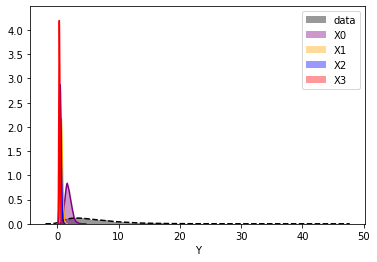

In [31]:
### Estimate scale (rate) using GLM-gamma with default inverse-power link
glm = smf.glm("Y ~ 1 + category + numerical", data=dummy_xy,family=sm.families.Gamma(link=sm.families.links.log()))
glm_fit = glm.fit()

# shape is 1/rate
shape = 1/glm_fit.scale
print('Shape :',shape)

# Remeber we drop a reference category for modelling
# For each categorical level
# intercept scale is
X0 = glm_fit.scale/glm_fit.params[0]
print('Scale X0: ',X0)


# scale for each categorical value is
X1 = glm_fit.scale/(glm_fit.params[0]+glm_fit.params[1])
print('Scale Xi: ',X1)
X2 = glm_fit.scale/(glm_fit.params[0]+glm_fit.params[2])
print('Scale Xi: ',X2)

# and for the numerical when 
# category = 2
# numerical = max
X3 = glm_fit.scale/(glm_fit.params[0]+glm_fit.params[2]+glm_fit.params['numerical']*dummy_xy['numerical'].max())

# plot
sns.distplot(dummy_xy.Y,color='black',label='data',kde_kws={'linestyle':'--'})
sns.distplot(np.random.gamma(shape=shape,scale=X0,size=10000),color='purple',label='X0')
sns.distplot(np.random.gamma(shape=shape,scale=X1,size=10000),color='orange',label='X1')
sns.distplot(np.random.gamma(shape=shape,scale=X2,size=10000),color='blue',label='X2')
sns.distplot(np.random.gamma(shape=shape,scale=X3,size=10000),color='red',label='X3')
plt.legend();

In [32]:
glm_fit.params

Intercept        0.559572
category[T.2]    0.932812
category[T.3]    1.429818
category[T.4]    1.838381
numerical        0.031512
dtype: float64

In [38]:
# So remember the model gives us the predicted mean value 
dummy_xy['pred-log'] = glm_fit.predict()
dummy_xy[:2]

,Y,category,numerical,pred-inv,pred-log
0,5.216028,2,0.377220,4.728714,4.500870
1,3.301647,2,2.995603,4.844136,4.887984


In [36]:
# dispersion aka rate
dispersion = glm_fit.scale
print('Disp',dispersion)

# shape is 1/dispersion
shape = 1/dispersion
print('Shape',shape)

# predicted mean G(Yi) is exp(Bo + Bi*Xi..)
# this is correctly getting the mean prediction
Yi = np.exp(glm_fit.params[0]+glm_fit.params['category[T.2]']+glm_fit.params['numerical']*dummy_xy['numerical'][0])
print('Yi',Yi)

# scale = Yi * dispersion
scale = Yi * dispersion
print('Scale',scale)

Disp 0.07619735419613495
Shape 13.12381526300718
Yi 4.500869625953329
Scale 0.34295435707939126


4.493724569167104


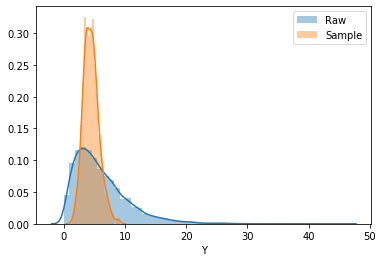

In [37]:
print(np.random.gamma(shape=shape,scale=scale,size=1000).mean())

sns.distplot(dummy_xy['Y'],label='Raw')
sns.distplot(np.random.gamma(shape=shape,scale=scale,size=1000),label='Sample')
plt.legend();

# Design Info
can we use design info to calculate the parameters for the whole dataset?

In [39]:
# use inverse-link as we know that this works
glm = smf.glm("Y ~ 1 + category + numerical", data=dummy_xy,family=sm.families.Gamma())
glm_fit = glm.fit()

C:\ProgramData\Anaconda3\envs\machine-learning\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:273: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)


In [40]:
# data values
a = pd.DataFrame(glm.data.exog,columns=glm.data.param_names)[:3]
a

,Intercept,category[T.2],category[T.3],category[T.4],numerical
0,1.0,1.0,0.0,0.0,0.377220
1,1.0,1.0,0.0,0.0,2.995603
2,1.0,1.0,0.0,0.0,6.256119


In [41]:
# glm coefficients
b = pd.DataFrame(glm_fit.params).T
b

,Intercept,category[T.2],category[T.3],category[T.4],numerical
0,0.554431,-0.342231,-0.425982,-0.467178,-0.001924


In [42]:
# but this only works if indexes are equal
c = a.multiply(b,axis=0)
c

,Intercept,category[T.2],category[T.3],category[T.4],numerical
0,0.554431,-0.342231,-0.0,-0.0,-0.000726
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN


In [43]:
# we can also just use arrays et voila
c = pd.DataFrame(glm.data.exog[:10,:] * glm_fit.params.values,columns=glm.data.param_names)
c

,Intercept,category[T.2],category[T.3],category[T.4],numerical
0,0.554431,-0.342231,-0.000000,-0.000000,-0.000726
1,0.554431,-0.342231,-0.000000,-0.000000,-0.005765
2,0.554431,-0.342231,-0.000000,-0.000000,-0.012039
3,0.554431,-0.000000,-0.425982,-0.000000,-0.003457
4,0.554431,-0.342231,-0.000000,-0.000000,-0.006060
5,0.554431,-0.000000,-0.000000,-0.000000,-0.002127
6,0.554431,-0.342231,-0.000000,-0.000000,-0.005258
7,0.554431,-0.342231,-0.000000,-0.000000,-0.009638
8,0.554431,-0.000000,-0.000000,-0.467178,-0.030043
9,0.554431,-0.342231,-0.000000,-0.000000,-0.005159


Sample Mu 4.66, Predicted Mu 4.73
Sample Mu 4.85, Predicted Mu 4.84
Sample Mu 5.05, Predicted Mu 5.00
Sample Mu 8.08, Predicted Mu 8.00
Sample Mu 4.90, Predicted Mu 4.85
Sample Mu 1.80, Predicted Mu 1.81
Sample Mu 4.81, Predicted Mu 4.83
Sample Mu 4.91, Predicted Mu 4.94
Sample Mu 17.17, Predicted Mu 17.48
Sample Mu 4.80, Predicted Mu 4.83


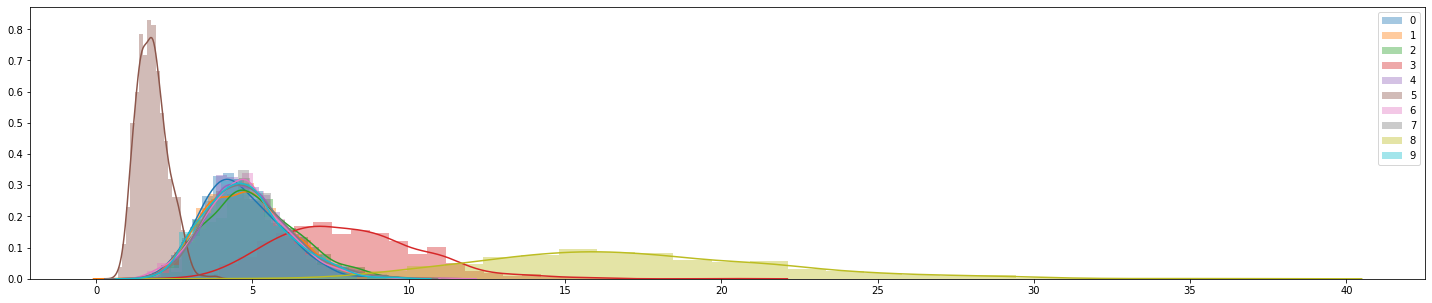

In [44]:
fig,axs = plt.subplots(1,1,figsize=(25,5))
for i,pred in zip(c.index,glm_fit.predict()[:10]):
    scale = glm_fit.scale/c.loc[[i]].sum(axis=1)
    sample = np.random.gamma(shape=1/glm_fit.scale,scale=scale,size=1000)
    sns.distplot(sample,label=i,ax=axs)
    print(f'Sample Mu {sample.mean():.2f}, Predicted Mu {pred:.2f}')
plt.legend();

***notes***

In [45]:
# inver link functions
# https://stats.stackexchange.com/a/393912/100439
glm_fit.predict(linear=True)

array([0.211474  , 0.20643516, 0.2001606 , ..., 0.21050209, 0.11441448,
       0.20605775])